In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from cnn.commons import full_inference_e2e, inc_inference_e2e,adaptive_drilldown, show_heatmap_on_image, heatmap_f1_score
from cnn.vgg16 import VGG16
from cnn.resnet18 import ResNet18
from cnn.vgg16_inc_v2 import IncrementalVGG16V2
from cnn.vgg16_inc_v1 import IncrementalVGG16V1
from cnn.resnet18_inc_v2 import IncrementalResNet18V2
from cnn.resnet18_inc_v1 import IncrementalResNet18V1

image_file_path = "../cnn/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
patch_size = 5
stride = 1

In [3]:
# torch.cuda.synchronize()
prev_time = time.time()
outputs_full = full_inference_e2e(ResNet18, image_file_path, patch_size, stride, interested_logit_index, batch_size=128)
torch.cuda.synchronize()
full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

../cnn/commons.py:127: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  orig_image = Variable(loader(orig_image).unsqueeze(0), volatile=True)


Full Inference Time: 24.4493069649


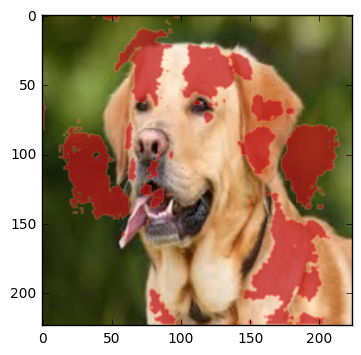

In [4]:
x = outputs_full
xmax, xmin = x.max(), x.min()
x = 1 - (x - xmin)/(xmax - xmin)

outputs_full_final = x
np.savetxt('temp', outputs_full_final)

show_heatmap_on_image(image_file_path, x, patch_size, stride)

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [8]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    torch.cuda.synchronize()
    if not adaptive:
        outputs_inc = inc_inference_e2e(IncrementalResNet18V2, image_file_path, patch_size, stride, interested_logit_index,
                                  batch_size=128, beta=beta, num_batches=-1)
    else:
        outputs_inc = adaptive_drilldown(IncrementalResNet18V2, image_file_path, patch_size, stride, interested_logit_index,
                                    batch_size=128, beta=beta, percentile=20, num_batches=-1)
    
    torch.cuda.synchronize()
    x = outputs_inc
    
    xmax, xmin = x.max(), x.min()
    x = 1 - (x - xmin)/(xmax - xmin)
    return x

### Path growth thresholding

BETA: 1.0 Inference Time: 11.2113039494


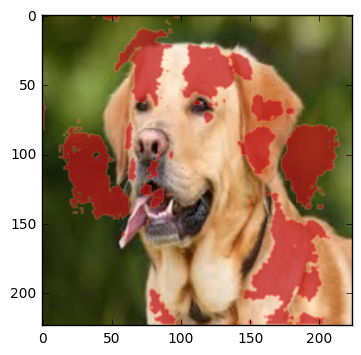

BETA: 0.9 Inference Time: 11.4019382


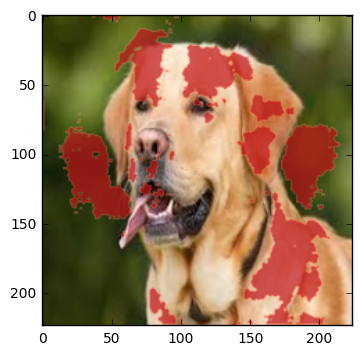

BETA: 0.8 Inference Time: 11.0757951736


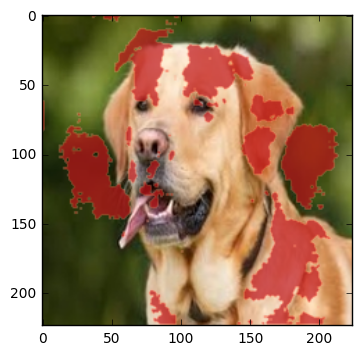

BETA: 0.7 Inference Time: 9.23861002922


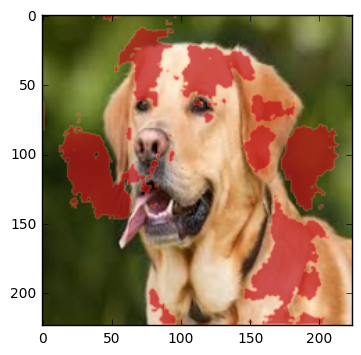

BETA: 0.6 Inference Time: 8.49426102638


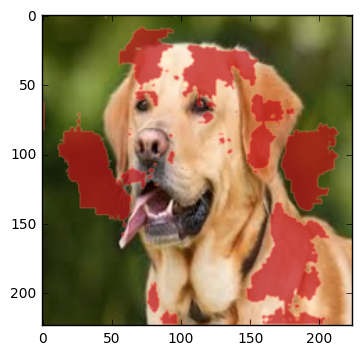

BETA: 0.5 Inference Time: 7.78351402283


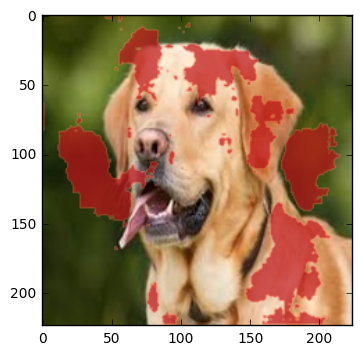

BETA: 0.4 Inference Time: 6.85475897789


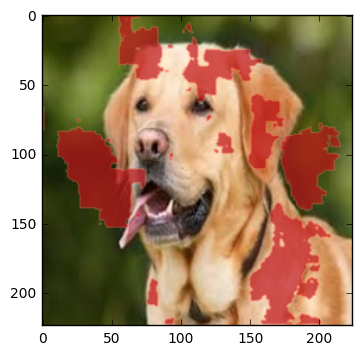

BETA: 0.3 Inference Time: 5.59777402878


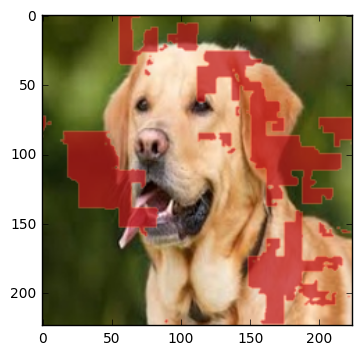

In [9]:
outputs_full_final = np.loadtxt('temp')
times = []
score = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    prev_time = time.time()
    outputs_inc_final = inc_inference(beta, patch_size=patch_size, stride=stride)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    score.append(1-heatmap_f1_score(outputs_full_final, outputs_inc_final))
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    show_heatmap_on_image(image_file_path, outputs_inc_final, patch_size, stride)

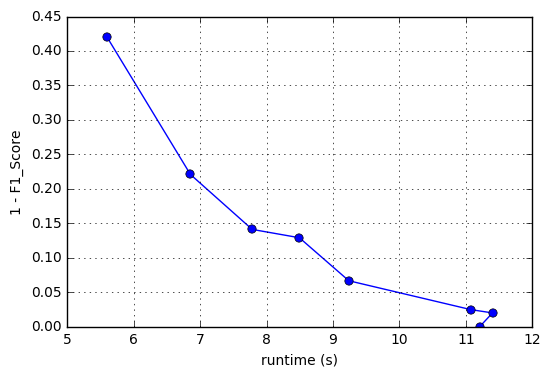

In [10]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('1 - F1_Score')

### Adaptive drill-down

BETA: 1.0 Inference Time: 7.95847988129


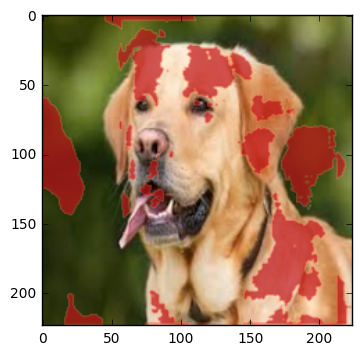

BETA: 0.9 Inference Time: 8.26852107048


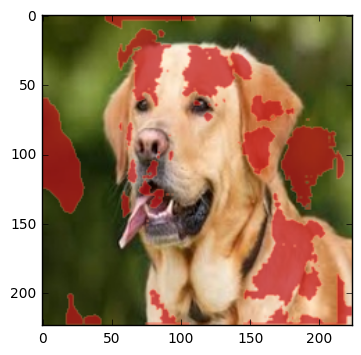

BETA: 0.8 Inference Time: 7.9985678196


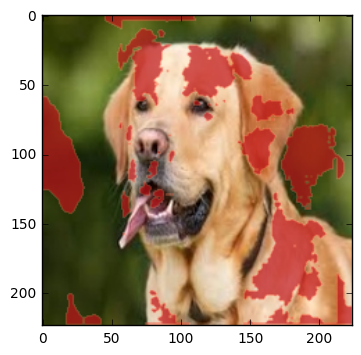

BETA: 0.7 Inference Time: 6.59691095352


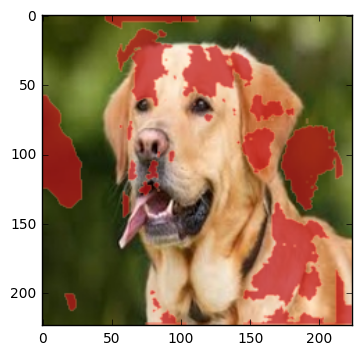

BETA: 0.6 Inference Time: 6.1029689312


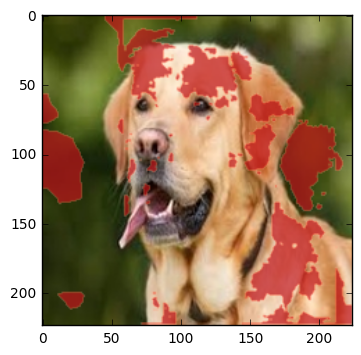

BETA: 0.5 Inference Time: 5.66041398048


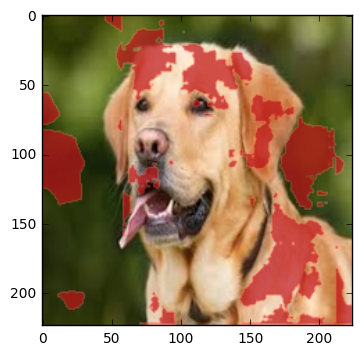

BETA: 0.4 Inference Time: 4.94007301331


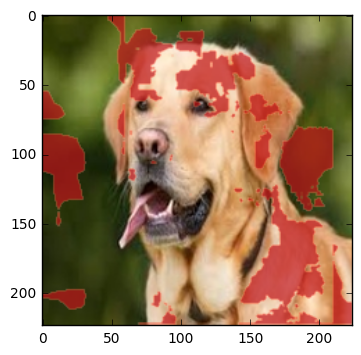

BETA: 0.3 Inference Time: 5.55990505219


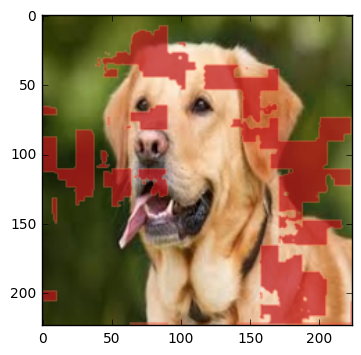

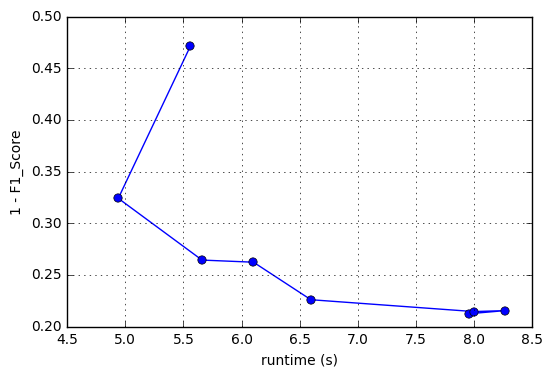

In [11]:
outputs_full_final = np.loadtxt('temp')
times = []
score = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    prev_time = time.time()
    outputs_inc_final = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    score.append(1-heatmap_f1_score(outputs_full_final, outputs_inc_final))
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    show_heatmap_on_image(image_file_path, outputs_inc_final, patch_size, stride)
    
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('1 - F1_Score')